In [1]:
%matplotlib inline
import os
import re
import io
import itertools
import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import climatools.lblnew.bestfit_params as bestfits
from climatools.lblnew import setup_bestfit, setup_overlap
import climatools.lblnew.pipeline as pipe_lblnew

import climatools.html.html as climahtml
from climatools.lblnew.dataio import *
from climatools.plot.plot import *

import IPython.display as display

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [2]:
%run param.py

In [3]:
def load_output_file(path_csv):
    '''
    Load lblnew output .csv file to xarray.Dataset
    
    Parameters
    ----------
    path_csv: str
              Path to the .csv file to be loaded.
    ds: xarray.Dataset
        Data in the input file in the form of an xarray.Dataset.
    '''
    toindex = ['band', 'pressure', 'igg', 'g']    
    df = pd.read_csv(path_csv, sep=r'\s+')
    df = df.set_index([i for i in toindex if i in df.columns])
    df = df.rename(columns={'sfu': 'flug',
                            'sfd': 'fldg',
                            'fnet': 'fnetg',
                            'coolr': 'coolrg'})
    ds = xr.Dataset.from_dataframe(df)

    for l in ('level', 'layer'):
        if l in ds.data_vars:
            if len(ds[l].dims) > 1:
                surface = {d: 0 for d in ds.dims if d != 'pressure'}
                coord_level = ds[l][surface]
                ds.coords[l] = ('pressure', coord_level)
            else:
                ds.coords[l] = ('pressure', ds[l])
    
    return ds

In [4]:
def lblnew_setup(param=None):
    if 'ng_refs' in param:
        return {'setup': setup_bestfit,
                'fname_flux_crd': 'output_flux.dat',
                'fname_cool_crd': 'output_coolr.dat',
                'fname_flux_wgt': 'output_wfluxg.dat',
                'fname_cool_wgt': 'output_wcoolrg.dat'}
    else:
        return {'setup': setup_overlap,
                'fname_flux_crd': 'output_flux.dat',
                'fname_cool_crd': 'output_coolr.dat',
                'fname_flux_wgt': 'output_wflux.dat',
                'fname_cool_wgt': 'output_wcoolr.dat'}

    
def load_lblnew_data(param):
    
    fname_dsname = [('fname_flux_crd', 'ds_flux_crd'),
                    ('fname_cool_crd', 'ds_cool_crd'),
                    ('fname_flux_wgt', 'ds_flux_wgt'),
                    ('fname_cool_wgt', 'ds_cool_wgt')]
    
    d = lblnew_setup(param)
    dir_fortran = pipe_lblnew.get_dir_case(param, setup=d['setup'])
    
    data_dict = {}
    for fname, dsname in fname_dsname:
        fpath = os.path.join(dir_fortran, d[fname])
        data_dict[dsname] = load_output_file(fpath)
    return data_dict
    

    
    

In [5]:
d = load_lblnew_data(PARAM)

DS_FLUX_CRD = d['ds_flux_crd']
DS_COOL_CRD = d['ds_cool_crd']
DS_FLUX_WGT = d['ds_flux_wgt']
DS_COOL_WGT = d['ds_cool_wgt']

In [6]:
def fmt_cool(ds_in):
    ds = ds_in.copy(deep=True)
    if 'igg' in ds.dims:
        ds = ds.sel(igg=1)

    if 'g' in ds.dims:
        ds = ds.sum('g')
            
    if 'band' in ds.dims:
        try:
            ds = ds.squeeze('band')
        except ValueError:
            ds = ds.sum('band')
                
    return ds['coolrg']


def pltdata_cooling_1(ds_cool_crd=None, ds_cool_wgt=None):
    data = [
        {'label': 'CRD',
         'srs': fmt_cool(ds_cool_crd),
         'linestyle': '-', 'color': 'blue', 'marker': None},
        {'label': 'WGT igg=10',
         'srs': fmt_cool(ds_cool_wgt.sel(igg=10)),
         'linestyle': '--', 'color': 'red', 'marker': None},
        {'label': 'WGT igg=1',
         'srs': fmt_cool(ds_cool_wgt.sel(igg=1)),
         'linestyle': '--', 'color': 'green', 'marker': None}
        ]
    return data


def plt_cooling(pltdata=None):
    '''
    Plots a list of cooling rate profiles.
    
    Parameter
    ---------
    pltdata: list-like
             List of dictionaries each of which contains the following
             fields:
                 label -- 
    '''
    
    plot_args = {'index_on_yaxis': True,
                 'yincrease': False,
                 'linewidth': 2,
                 'grid': True,
                 'alpha': .7}
    
    yscales = ['linear', 'log']
    varlims = [(50, 1050), (1e-2, 200)]
    
    fig, axs = plt.subplots(ncols=len(yscales), nrows=1,
                            figsize=(15, 6))
    
    axs = axs.flatten()
    
    for ax, yscale, varlim in zip(axs, yscales, varlims):
        for d in pltdata:
            d['srs'].climaviz.plot(ax=ax,
                                  yscale=yscale,
                                   varlim_from_indexrange=varlim,
                                  label=d['label'],
                                  linestyle=d['linestyle'],
                                  color=d['color'],
                                  marker=d['marker'],
                                  **plot_args)
            
        ax.set_title('')
        
        ax.set_ylabel('Pressure (mb)')
        ax.set_ylim(top=1e-2)
        ax.set_ylim(bottom=None)
    
        ax.set_xlabel('Cooling rate (degree per day)')
    return fig, axs



def script_plt_cooling():
    pltdata = pltdata_cooling_1(
        ds_cool_crd=DS_COOL_CRD,
        ds_cool_wgt=DS_COOL_WGT)
    fig, axs = plt_cooling(pltdata=pltdata)
    display.display(fig)
    print('''FIGURE. Cooling rate profiles.''')
    plt.close(fig)

In [7]:
def fmt_flux(ds_in):
    ds = ds_in.copy(deep=True)
    
    for l in ('level', 'layer'):
        if l in ds.data_vars:
            if len(ds[l].dims) > 1:
                surface = {d: 0 for d in ds.dims if d != 'pressure'}
                coord_level = ds[l][surface]
                ds.coords[l] = ('pressure', coord_level)
            else:
                ds.coords[l] = ('pressure', ds[l])
        
    ds = ds.isel(pressure=[0, 23, -1])
    
    if 'igg' in ds.dims:
        if ds.dims['igg'] > 1:
            print('Select an igg value to view in table.')
            raise ValueError
        else:
            ds = ds.squeeze('igg').drop('igg')
    else:
        if 'igg' in ds.coords:
            ds = ds.drop('igg')

    if 'g' in ds.dims:
        ds = ds.sum('g')
            
    if 'band' in ds.dims:
        try:
            ds = ds.squeeze('band').drop('band')
        except ValueError:
            ds = ds.sum('band')
                
    df = ds.to_dataframe()
    df = df.set_index('level', append=True)               
    return df


def tbdata_flux(ds_flux_crd=None, ds_flux_wgt=None):
    ilevels = [0, 23, -1]
            
    benchmark = {'label': 'CRD',
                 'df': fmt_flux(ds_flux_crd)}
    tbs = [{'label': 'WGT igg=10',
            'df': fmt_flux(ds_flux_wgt.sel(igg=10))},
           {'label': 'WGT igg=1',
            'df': fmt_flux(ds_flux_wgt.sel(igg=1))}]
    
    data = {'benchmark': benchmark, 'others': tbs}
    return data


def tb_flux(tbdata=None):
    benchmark = tbdata['benchmark']
    others = tbdata['others']
    
    def show_tb(d=None):
        display.display(d['df'])
        print('Table.', 'Fluxes.', d['label'])
        
    def show_tbdiff(d0=None, d=None):
        df = d['df']
        df.index = d0['df'].index
        display.display(df - d0['df'])
        print('Table.', 'Fluxes.', 
              '({}) - ({})'.format(d['label'], d0['label']))
        
    show_tb(benchmark)
    for d in others:
        show_tb(d)
        
    for d in others:
        show_tbdiff(d=d, d0=benchmark)
        
        
def script_tb_flux():
    data = tbdata_flux(ds_flux_crd=DS_FLUX_CRD,
                       ds_flux_wgt=DS_FLUX_WGT)
    tb_flux(tbdata=data)

In [8]:
def band_map():
    '''
    Maps spectral bands in lblnew to spectral bands in clirad.
    '''
    lblnew2clirad = {'1': '1',
            '2': '2',
            '3a': '3',
            '3b': '4',
            '3c': '5',
            '4': '6', 
            '5': '7',
            '6': '8',
            '7': '9', 
            '8': '10',
            '9': '11'}
    
    clirad2lblnew = {clirad: lblnew 
                     for lblnew, clirad in lblnew2clirad.items()}
    return clirad2lblnew


def gasbands():
    bmap = band_map()
    gases = list(PARAM['molecule'].keys())
    
    bands = [PARAM['band']]
    return list(itertools.product(gases, bands))


def print_bestfit_params():
    print('Best-fit values for each (gas, band)')
    print('------------------------------------')
    for gas, band in gasbands():
        print('o {} band{}'.format(gas, band))
        param = bestfits.kdist_params(molecule=gas, band=band)
        for name, value in param.items():
            print(2 * ' ' + '{} = {}'.format(name, value))

        
def print_input_param():        
    for name, value in PARAM.items():
        print('{} = {}'.format(name, value))


In [9]:
def show_html(s):
    display.display(display.HTML(s))

    
def show_markdown(s):
    display.display(display.Markdown(s))

    
def script():
    
    title = '### LBLNEW-OVERLAP'
    s_input = 'Input Parameters'
    s_bestfits = 'Best-fit Parameters'
    s_plt_cooling = 'Cooling Rate Profiles'
    s_tb_flux = 'Flux Comparison'
    
    # title
    show_markdown(title)
    
    # TOC
    show_markdown('### Table of Contents')
    show_html(climahtml.getHTML_hrefanchor(s_input))
    show_html(climahtml.getHTML_hrefanchor(s_plt_cooling))
    show_html(climahtml.getHTML_hrefanchor(s_tb_flux))
    show_html(climahtml.getHTML_hrefanchor(s_bestfits))
    
    # Input parameters
    show_html(climahtml.getHTML_idanchor(s_input))
    show_markdown(climahtml.getMarkdown_sectitle(s_input))
    print_input_param()
    
    # Cooling rate profiles
    show_html(climahtml.getHTML_idanchor(s_plt_cooling))
    show_markdown(climahtml.getMarkdown_sectitle(s_plt_cooling))
    script_plt_cooling()
    
    # Flux comparison
    show_html(climahtml.getHTML_idanchor(s_tb_flux))
    show_markdown(climahtml.getMarkdown_sectitle(s_tb_flux))
    script_tb_flux()
    
    # Best-fit values
    show_html(climahtml.getHTML_idanchor(s_bestfits))
    show_markdown(climahtml.getMarkdown_sectitle(s_bestfits))
    print_bestfit_params()
   
    

### LBLNEW-OVERLAP

### Table of Contents

# Input Parameters

commitnumber = a22ab94
molecule = {'h2o': 'atmpro', 'co2': 0.0004, 'n2o': 6.4e-07}
band = 3a
nv = 1000
dv = 0.001
atmpro = trp
tsfc = 300


# Cooling Rate Profiles

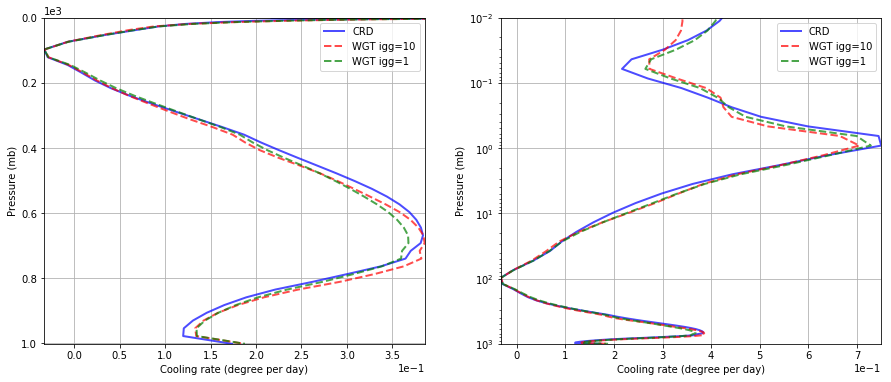

FIGURE. Cooling rate profiles.


# Flux Comparison

,,flug,fldg,fnetg
pressure,level,,,
0.0000,1,-24.874534,0.000000,-24.874534
1.0685,24,-24.877389,0.078887,-24.798503
1013.0000,76,-38.491734,37.340259,-1.151475


Table. Fluxes. CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0000,1,-25.137093,0.000000,-25.137093
1.0685,24,-25.137030,0.070392,-25.066638
1013.0000,76,-38.491734,37.141524,-1.350210


Table. Fluxes. WGT igg=10


,,flug,fldg,fnetg
pressure,level,,,
0.0000,1,-24.916362,0.000000,-24.916362
1.0685,24,-24.916914,0.073995,-24.842918
1013.0000,76,-38.491734,37.002077,-1.489657


Table. Fluxes. WGT igg=1


,,flug,fldg,fnetg
pressure,level,,,
0.0000,1,-0.262559,0.000000,-0.262559
1.0685,24,-0.259641,-0.008494,-0.268135
1013.0000,76,0.000000,-0.198735,-0.198735


Table. Fluxes. (WGT igg=10) - (CRD)


,,flug,fldg,fnetg
pressure,level,,,
0.0000,1,-0.041828,0.000000,-0.041828
1.0685,24,-0.039525,-0.004891,-0.044415
1013.0000,76,0.000000,-0.338182,-0.338182


Table. Fluxes. (WGT igg=1) - (CRD)


# Best-fit Parameters

Best-fit values for each (gas, band)
------------------------------------
o h2o band3a
  molecule = h2o
  band = 3a
  commitnumber = a06b618
  vmin = 540
  vmax = 620
  dv = 0.001
  nv = 1000
  ref_pts = [(10, 250), (600, 250)]
  ng_refs = [2, 6]
  ng_adju = [0, 0]
  klin = 0
  option_wgt_k = 1
  wgt = [(0.7, 0.7), (0.7, 0.5, 0.5, 0.5, 0.5, 0.5)]
  w_diffuse = [(1.9, 1.7), (1.4, 1.4, 1.4, 1.55, 1.6, 1.66)]
  option_wgt_flux = 1
  atmpro = mls
  tsfc = 294
  conc = None
  option_compute_btable = 0
  option_compute_ktable = 1
o co2 band3a
  molecule = co2
  band = 3a
  commitnumber = a06b618
  vmin = 540
  vmax = 620
  dv = 0.001
  nv = 1000
  ref_pts = [(1, 250), (10, 250), (500, 250)]
  ng_refs = [3, 2, 4]
  ng_adju = [0, 0, 0]
  klin = 6.375563e-24
  option_wgt_k = 1
  wgt = [(0.7, 0.3, 0.7), (0.7, 0.6), (0.4, 0.5, 0.8, 0.95)]
  w_diffuse = [(1.6, 1.6, 1.7), (1.75, 1.75), (1.55, 1.55, 1.6, 1.85)]
  option_wgt_flux = 1
  atmpro = mls
  tsfc = 294
  conc = 0.0004
  option_compute_btable

In [10]:
script()

In [11]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')